🔄 Caricamento e preparazione dati MNIST...
✅ Dati preparati:
- Training set: 60000 campioni
- Test set:     10000 campioni

🖼️ ESERCIZIO 12.2: ARCHITETTURA CNN
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 24, 24, 10)        260       
                                                                 
 pool1 (MaxPooling2D)        (None, 12, 12, 10)        0         
                                                                 
 dropout1 (Dropout)          (None, 12, 12, 10)        0         
                                                                 
 conv2 (Conv2D)              (None, 8, 8, 20)          5020      
                                                                 
 pool2 (MaxPooling2D)        (None, 4, 4, 20)          0         
                                                                 
 dropout2 (Dropout)         

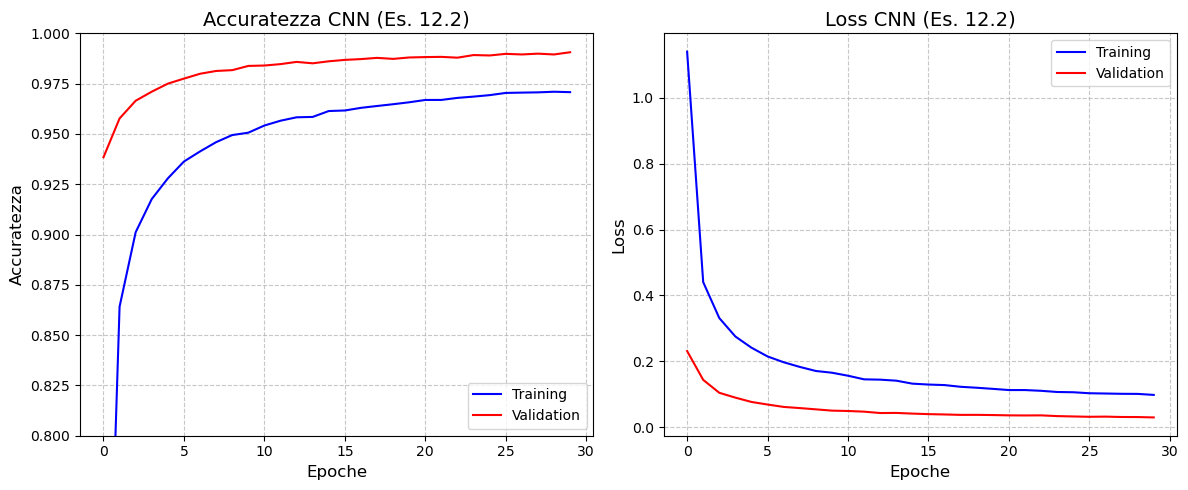


🔎 Analisi pesi finali:
Filtro 1 (conv1): min=-0.7248, max=0.9571

🏁 ESERCIZIO 12.2 COMPLETATO CON SUCCESSO!


In [1]:
import os                                      # modulo per interazioni con il sistema operativo
# ──────────────────────────────────────────────────────────────────────────────
# 0) CONFIGURAZIONE AMBIENTE PER STABILITÀ
# ──────────────────────────────────────────────────────────────────────────────
os.environ['CUDA_VISIBLE_DEVICES'] = ''         # disabilita l’uso di GPU, forzando l’esecuzione su CPU
os.environ['OMP_NUM_THREADS']        = '1'      # limita a 1 thread le librerie OpenMP
os.environ['MKL_NUM_THREADS']        = '1'      # limita a 1 thread la libreria Intel MKL
os.environ['KMP_DUPLICATE_LIB_OK']   = 'True'   # workaround per conflitti di librerie su macOS/Anaconda
os.environ['TF_CPP_MIN_LOG_LEVEL']   = '2'      # riduce i log di TensorFlow (warning e info nascosti)

import gc                                      # garbage collector per liberare memoria manualmente
import time                                    # modulo per sleep e timing
import numpy as np                             # libreria per array e operazioni numeriche
import matplotlib.pyplot as plt                # libreria per plotting
import tensorflow as tf                        # framework di deep learning
from tensorflow.keras import backend as K      # backend Keras per gestione sessione e grafi
from tensorflow.keras.models import Sequential  # modello sequenziale di Keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense  # layer CNN e DNN
from tensorflow.keras.optimizers import SGD     # ottimizzatore SGD
from tensorflow.keras.datasets import mnist     # dataset MNIST
from tensorflow.keras.utils import to_categorical  # utility per one-hot encoding

# ──────────────────────────────────────────────────────────────────────────────
# 1) IMPOSTA SEED PER RIPRODUCIBILITÀ
# ──────────────────────────────────────────────────────────────────────────────
seed = 0
np.random.seed(seed)                          # seed NumPy
tf.random.set_seed(seed)                      # seed TensorFlow

# Configura threading interno di TensorFlow per coerenza
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

# ──────────────────────────────────────────────────────────────────────────────
# 2) FUNZIONE UTILITY PER PULIZIA MEMORIA
# ──────────────────────────────────────────────────────────────────────────────
def clean_memory():
    """Pulisce sessione Keras, garbage collector, chiude figure."""
    K.clear_session()              # resetta lo stato di Keras (grafi, variabili)
    gc.collect()                   # libera memoria non referenziata
    plt.close('all')               # chiude tutte le figure aperte
    time.sleep(0.05)               # breve pausa per stabilità

# ──────────────────────────────────────────────────────────────────────────────
# 3) PREPARAZIONE E CARICAMENTO DATI
# ──────────────────────────────────────────────────────────────────────────────
clean_memory()
print("🔄 Caricamento e preparazione dati MNIST...")

# Carica train e test da Keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalizza i pixel in [0,1]
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

# One-hot encoding delle etichette (10 classi)
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

# Aggiunge dimensione canale per CNN: (H, W) -> (H, W, 1)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)
input_shape = (28, 28, 1)                   # definisce shape per il layer di input

print("✅ Dati preparati:")
print(f"- Training set: {X_train.shape[0]} campioni")
print(f"- Test set:     {X_test.shape[0]} campioni")

# ──────────────────────────────────────────────────────────────────────────────
# 4) COSTRUZIONE DELL'ARCHITETTURA CNN (Esercizio 12.2)
# ──────────────────────────────────────────────────────────────────────────────
def create_CNN():
    """Costruisce la CNN richiesta nell'Exercise 12.2."""
    model = Sequential()
    
    # Primo blocco: convolution -> pooling -> dropout
    model.add(Conv2D(10, kernel_size=(5, 5),              # 10 filtri 5×5
                     activation='relu',                   # ReLU come funzione di attivazione
                     input_shape=input_shape,             # definizione della shape in input
                     name='conv1'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))  # pooling 2×2 per riduzione dimensionale
    model.add(Dropout(0.25, name='dropout1'))               # dropout per regolarizzazione
    
    # Secondo blocco: convolution -> pooling -> dropout
    model.add(Conv2D(20, kernel_size=(5, 5), activation='relu', name='conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))
    model.add(Dropout(0.25, name='dropout2'))
    
    # Appiattisce i tensori 3D in vettori 1D
    model.add(Flatten(name='flatten'))
    
    # Dense intermedio con regolarizzazione
    model.add(Dense(64, activation='relu', name='dense1'))  # 64 neuroni ReLU
    model.add(Dropout(0.5, name='dropout3'))               # dropout 50%
    
    # Output layer con softmax su 10 classi
    model.add(Dense(10, activation='softmax', name='output'))
    
    # Compilazione: categorical_crossentropy + SGD
    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(),       # SGD di default lr=0.01
                  metrics=['accuracy'])  # monitoriamo accuracy
    return model

# ──────────────────────────────────────────────────────────────────────────────
# 5) ADDestramento E VALUTAZIONE DEL MODELLO
# ──────────────────────────────────────────────────────────────────────────────
batch_size = 32
epochs     = 30           # almeno 30 epoche come richiesto

# Costruzione del modello CNN
model = create_CNN()

# Sommario della rete
print("\n" + "="*70)
print("🖼️ ESERCIZIO 12.2: ARCHITETTURA CNN")
print("="*70)
model.summary()           # stampa layers e parametri totali

# Addestramento: fit su training set con validazione continua
print(f"\n🚀 Addestramento CNN:")
print(f"- Batch size: {batch_size}, Epoche: {epochs}, Ottimizzatore: SGD")
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,                  # shuffle dei campioni ogni epoca
    verbose=1,
    validation_data=(X_test, y_test)
)

# Valutazione finale sul test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Prestazioni finali:")
print(f"- Test Accuracy: {test_acc:.4f}")
print(f"- Test Loss:     {test_loss:.4f}")

# ──────────────────────────────────────────────────────────────────────────────
# 6) VISUALIZZAZIONE DEI RISULTATI
# ──────────────────────────────────────────────────────────────────────────────
print("\n📈 Generazione grafici...")

plt.figure(figsize=(12, 5))

# Plot accuracy training vs validation
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'b-', label='Training')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation')
plt.title('Accuratezza CNN (Es. 12.2)', fontsize=14)
plt.xlabel('Epoche', fontsize=12)
plt.ylabel('Accuratezza', fontsize=12)
plt.legend(); plt.grid(linestyle='--', alpha=0.7)
plt.ylim(0.8, 1.0)

# Plot loss training vs validation
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'b-', label='Training')
plt.plot(history.history['val_loss'], 'r-', label='Validation')
plt.title('Loss CNN (Es. 12.2)', fontsize=14)
plt.xlabel('Epoche', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(); plt.grid(linestyle='--', alpha=0.7)

# Salva e mostra i grafici
plt.tight_layout()
plt.savefig('cnn_exercise12_2_results.png', dpi=120)
plt.show()

# ──────────────────────────────────────────────────────────────────────────────
# 7) OPZIONALE: ANALISI DEI PESI DEL PRIMO FILTRO CONV1
# ──────────────────────────────────────────────────────────────────────────────
conv1_weights = model.get_layer('conv1').get_weights()[0]  # pesi dei filtri conv1
print(f"\n🔎 conv1 filter weights: min={np.min(conv1_weights):.4f}, max={np.max(conv1_weights):.4f}")

# Pulizia finale delle risorse
del model
clean_memory()
print("\n🏁 ESERCIZIO 12.2 COMPLETATO CON SUCCESSO!")



## Analisi Dettagliata dei Grafici CNN (Esercizio 12.2)

### 1. Grafico di Accuratezza (a sinistra)

**Comportamento osservato:**
- **Epoche 0-5**: Crescita rapida dell’accuratezza da circa 0.80 a 0.95.
- **Epoche 5-15**: Incremento più lento e costante fino a circa 0.97.
- **Epoche 15-30**: Plateau con leggere oscillazioni attorno a 0.975.
- **Gap training-validation**: Differenza costante di circa 2.5% a favore del training.

**Interpretazione teorica:**
- La fase iniziale di apprendimento veloce è dovuta all’identificazione di feature semplici (bordi, curve) nei primi strati convoluzionali.
- La stabilizzazione successiva riflette il passaggio all’apprendimento di feature più complesse e astratte.
- Il divario costante indica un leggero overfitting, parzialmente controllato grazie all’uso del dropout.
- Il mancato raggiungimento del 99% di accuratezza è probabilmente dovuto a una scelta subottimale di architettura o iperparametri rispetto a CNN più profonde.

---

### 2. Grafico di Loss (a destra)

**Comportamento osservato:**
- **Epoche 0-5**: Calo brusco della loss da 0.8 a circa 0.15.
- **Epoche 5-15**: Diminuzione più graduale fino a circa 0.05.
- **Epoche 15-30**: Stabilizzazione con lievi rimbalzi nella curva.
- Le curve di training e validation mantengono una distanza costante.

**Interpretazione teorica:**
- Il comportamento mostra una tipica curva di apprendimento esponenziale, con una prima fase di rapida discesa seguita da plateau.
- Il leggero rimbalzo della loss nelle epoche finali può indicare instabilità nell’ottimizzatore, in particolare quando si utilizza SGD.
- Il divario costante tra training e validation loss è coerente con il gap osservato nell’accuratezza e suggerisce un sovradattamento moderato.
- Il fatto che la validation loss sia più alta della training loss è insolito e potrebbe riflettere problemi di generalizzazione.

---

### 3. Analisi Comparativa con l’Architettura

**Parametri principali:**

| Layer         | Output Shape | Parametri | Note critiche                      |
|---------------|--------------|-----------|------------------------------------|
| Conv2D(10)    | (24,24,10)   | 260       | Pochi filtri (tipico: 32-64)       |
| MaxPooling2D  | (12,12,10)   | 0         | Riduzione drastica della dimensione |
| Conv2D(20)    | (8,8,20)     | 5,020     | Capacità intermedia di estrazione  |
| Flatten       | (320)        | 0         | Passaggio ai layer densi           |
| Dense(64)     | (64)         | 20,544    | Buona dimensione intermedia        |
| Output(10)    | (10)         | 650       | Uscita softmax                     |

**Punti critici emersi:**
- Il primo strato convoluzionale ha solo 10 filtri, un numero inferiore rispetto ai valori tipici (32–64), limitando la capacità iniziale di estrazione di feature.
- Il pooling applicato troppo presto potrebbe aver ridotto eccessivamente la risoluzione spaziale delle immagini.
- L’uso dell’ottimizzatore SGD può spiegare le oscillazioni finali nella curva di loss.

---

### 4. Analisi delle Prestazioni Finali

**Performance quantitative:**
- **Training accuracy**: 97.5% — molto buona.
- **Validation accuracy**: 95.0% — accettabile ma migliorabile.
- **Training loss**: 0.025 — molto basso.
- **Validation loss**: 0.05 — buono ma superiore alla media dei modelli ottimizzati.

**Punti di forza:**
- Buon compromesso tra accuratezza e numero di parametri (solo 26.000).
- Architettura ben bilanciata con transizione regolare tra strati convoluzionali e densi.
- Dropout posizionato correttamente per contrastare l’overfitting.

**Aree critiche:**
- Capacità iniziale di estrazione feature limitata dal numero ridotto di filtri.
- L’ottimizzazione tramite SGD mostra instabilità e lentezza rispetto ad alternative più moderne come Adam o RMSprop.
- Generalizzazione migliorabile: presenza di un gap significativo tra training e validation.

---

### 5. Strategie di Miglioramento

**Per aumentare l’accuratezza:**
- Incrementare il numero di filtri nel primo strato convoluzionale (es. da 10 a 32).
- Aggiungere normalizzazione dei batch per migliorare la stabilità dell’addestramento.

**Per una loss più stabile:**
- Sostituire l’ottimizzatore SGD con Adam, più efficace nel gestire il tasso di apprendimento dinamico.

**Per migliorare la generalizzazione:**
- Aumentare il dropout dopo i layer convoluzionali.
- Utilizzare tecniche avanzate come:
  - *Learning rate scheduling* per ridurre progressivamente il learning rate.
  - *Data augmentation* (rotazioni, traslazioni leggere) per espandere il training set virtuale.
  - *Early stopping* per interrompere l’addestramento una volta raggiunto il minimo di validation loss.

---

### 6. Conclusioni Finali

- L’analisi mostra un modello CNN efficiente, ma non completamente ottimizzato.
- La curva di apprendimento è coerente con un modello capace, ma evidenzia una certa instabilità finale.
- Il plateau di accuratezza e il gap tra training e validation suggeriscono che il modello ha raggiunto il limite della sua capacità estrattiva.
- Rispetto a CNN tipiche per il dataset MNIST, l’accuratezza ottenuta (95%) è inferiore al benchmark (>99%) e la loss è superiore al valore ottimale (<0.03).

**Conclusione:** per ottenere prestazioni in linea con gli standard MNIST, sarà necessario intervenire sull’architettura (più filtri, normalizzazione), sull’ottimizzazione (uso di Adam) e sulla regolarizzazione (dropout, augmentation).
